In [2]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py, matplotlib
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    from BEMHelper import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from HeliumSurface.static_surface import *
from ipywidgets import interact
import glob, re
from pprint import pprint
from scipy.constants import elementary_charge as qe, electron_mass as me

matplotlib.rcParams['pdf.fonttype'] = 42
%matplotlib inline

In [3]:
def load_dsp(df, line_nr=[91, 92, 93, 120]):
    """
    Loads a .dsp file from Maxwell and extracts elements, nodes and the solution at the nodes.
    For this code to work, the data must have been saved as a dsp file, with only a single plot in the Fields tab.
    :param df: File path of the data file
    :return: elements, node, element solution, bounding box
    """
    with open(df, 'r') as myfile:
        data = myfile.readlines()

    # The important data is stored on line numbers 91-93.
    # Line 91: Elements: Each element is composed of 6 nodes. Each sequence of 2,3,3,0,6 is followed by 6 points, which will
    # make up a single element. First 2 entries are diagnostic info.
    # Line 92: Node coordinates. One node coordinate has 3 entries: x, y, z
    # Line 93: Solution on each node. First 3 entries are diagnostic info.

    elements = np.array(re.findall(r"\((.*?)\)", data[line_nr[0]-1])[0].split(', '), dtype=int)
    nodes = np.array(re.findall(r"\((.*?)\)", data[line_nr[1]-1])[0].split(', '), dtype=float)
    elem_solution = np.array(re.findall(r"\((.*?)\)", data[line_nr[2]-1])[0].split(', '), dtype=float)

    nodes = nodes.reshape((int(nodes.shape[0]/3), 3))

#     line_nr = 90
    bounding_box = np.array(re.findall(r"\((.*?)\)", data[line_nr[3]-1])[0].split(', '), dtype=float)

    return elements, nodes, elem_solution[3:], bounding_box

## Potential slices

11it [01:06,  5.79s/it]
11it [00:45,  3.82s/it]
11it [02:09, 10.41s/it]
11it [02:12, 10.49s/it]


Plotting results for h = 1.18 μm
The file contains heights from h = 1.1 μm to h = 1.2 μm


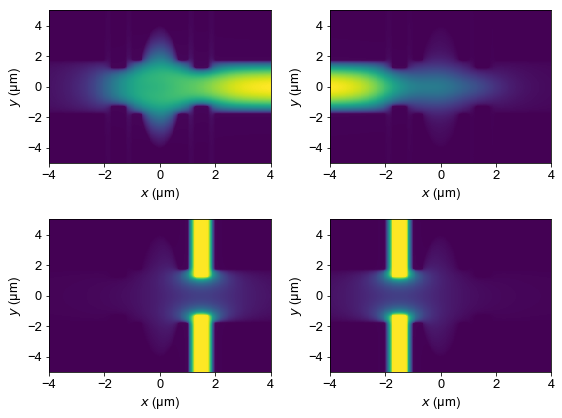

In [4]:
# lines = [[121, 122, 123, 120], 
#          [132, 133, 134, 131], 
#          [143, 144, 145, 142]]

Nheights = 11

names = ["Resonator", "Trap", "Resonatorguard", "Trapguard"]
# lines = [[391 + 11*k, 392 + 11*k, 393 + 11*k, 390 + 11*k] for k in range(Nheights)]
# lines = [[4+391 + 11*k, 4+392 + 11*k, 4+393 + 11*k, 4+390 + 11*k] for k in range(Nheights)] # For .dsp files from Ansys 18 (2017 version)
lines = [[418 + 12*k, 419 + 12*k, 420 + 12*k, 417 + 12*k] for k in range(Nheights)] # For .dsp files from Ansys 18 (2017 version)


xeval = np.linspace(-4., 4., 251)
yeval = anneal.construct_symmetric_y(-5, 401)

fig = plt.figure(figsize=(2*4., 2*3.))
common.configure_axes(13)

output = list()
for mm, name in enumerate(names):
    datapath = r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6\With L3 etch - just trap\Multiple h with smooth corners (1100 - 1200 nm) and d = 1200 nm Take 2"
    df = os.path.join(datapath, "%s.dsp" % name)

    for nn, linez in tqdm(enumerate(lines)):
        elements, nodes, solution, bbox = load_dsp(df, line_nr=linez)
#         print("h = ",bbox[4], "um")
        xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, solution)
        xcenter = np.mean(bbox[0:2])
        ycenter = np.mean(bbox[2:4])
        xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=None, 
                                                             plot_axes='xy', cmap=plt.cm.viridis, plot_mesh=False, plot_data=0)

        # Mirror around the y-axis
        ysize, xsize = np.shape(Uinterp)
        Uinterp_symmetric = np.zeros((2 * ysize, xsize))
        Uinterp_symmetric[:ysize, :] = Uinterp
        Uinterp_symmetric[ysize:, :] = Uinterp[::-1, :]

        y_symmetric = np.zeros((2 * ysize, xsize))
        y_symmetric[:ysize, :] = yinterp
        y_symmetric[ysize:, :] = -yinterp[::-1, :]

        x_symmetric = np.zeros((2 * ysize, xsize))
        x_symmetric[:ysize, :] = xinterp
        x_symmetric[ysize:, :] = xinterp

        if nn == 0:
            output.append({'name' : name, 
                   'V' : np.zeros((2 * ysize, xsize, Nheights), dtype=np.float64),
                   'x' : np.zeros((2 * ysize, xsize, Nheights), dtype=np.float64), 
                   'y' : np.zeros((2 * ysize, xsize, Nheights), dtype=np.float64), 
                   'helium_height' : np.zeros(Nheights)})

        output[mm]['V'][:, :, nn] = Uinterp_symmetric
        output[mm]['x'][:, :, nn] = x_symmetric
        output[mm]['y'][:, :, nn] = y_symmetric
        output[mm]['helium_height'][nn] = bbox[4]
    
    # Sort according to ascending helium height
    proper_order = np.argsort(output[mm]['helium_height'])
    output[mm]['helium_height'] = output[mm]['helium_height'][proper_order]
    output[mm]['x'] = output[mm]['x'][:, :, proper_order]
    output[mm]['y'] = output[mm]['y'][:, :, proper_order]
    output[mm]['V'] = output[mm]['V'][:, :, proper_order]

    plt.subplot(2, 2, mm+1)
    plt.pcolormesh(x_symmetric, y_symmetric, Uinterp_symmetric)
#     plt.title(r"$h$ = %s $\mu$m" % bbox[4])
    plt.xlabel(r"$x$ (%sm)" % (chr(956)))
    plt.ylabel(r"$y$ (%sm)" % (chr(956)))
    
hs = np.array(output[0]['helium_height'])
print(r"Plotting results for h = %s %sm" % (bbox[4], chr(956)))
print(r"The file contains heights from h = %s %sm to h = %s %sm" % (np.min(hs), chr(956), np.max(hs), chr(956)))
fig.tight_layout()

101it [00:01, 85.26it/s]
101it [00:01, 82.88it/s]
101it [00:01, 80.19it/s]
101it [00:01, 80.06it/s]
101it [00:01, 84.83it/s]
101it [00:01, 86.01it/s]
101it [00:01, 89.32it/s]


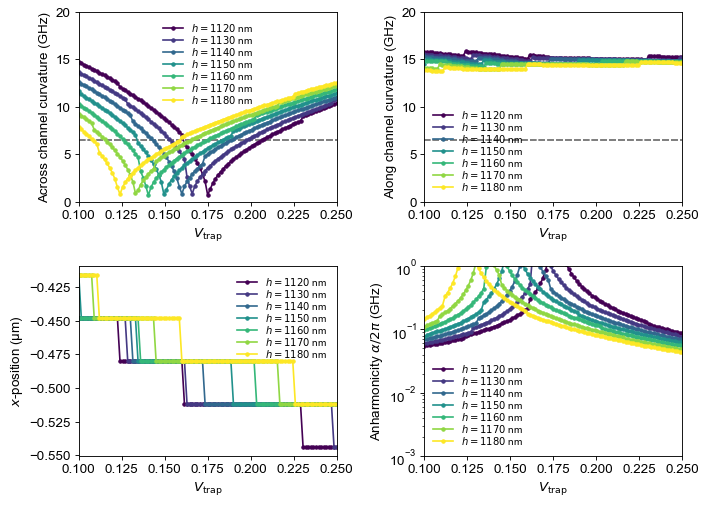

In [5]:
selection = np.arange(2, 9)
hs = np.array(output[0]['helium_height'])[selection]
fit_potential_minimum=True
Npts = 101

# mu = -0.515
# xsep = 0.63

# def f_mu(mu):
#     return -2.80 - 6.83*mu

mu = -0.270
xsep = 0.34

def f_mu(mu):
    return -1.755 - 7*mu

Vtrap_park = 0.25
Vtrap_stop = 0.10

# Vtrap_park = 0.7
# Vtrap_stop = 0.3
Vrg_start = -1/2.45*(Vtrap_park - (f_mu(mu)))-xsep
Vrg_stop = -1/2.45*(Vtrap_stop - (f_mu(mu)))-xsep

Vtraps = np.linspace(Vtrap_park, Vtrap_stop, Npts)
Vresguards = np.linspace(Vrg_start, Vrg_stop, Npts)
resonator = 0.60
trapguard = 0.00

# Evaluate all files in the range
xeval = np.linspace(-2, 2, 501)
yeval = anneal.construct_symmetric_y(-4, 201)

names = ['resonator', 'trap', 'resonatorguard', 'trapguard']
colors = [plt.cm.viridis(x) for x in np.linspace(0, 1.0, len(selection))]
electron_frequencies = list()

fig = plt.figure(figsize=(9.,6.5))
common.configure_axes(12)

iteration = 0

for mm, h in zip(selection, hs):
    efreqs_x = np.zeros(len(Vtraps))
    efreqs_y = np.zeros(len(Vtraps))
    xposition = np.zeros(len(Vtraps))
    barrier_height = np.zeros(len(Vtraps))
    barrier_height_minus_trap = np.zeros(len(Vtraps))
    barrier_minus_mu = np.zeros(len(Vtraps))
    trap_level = np.zeros(len(Vtraps))
    quartic_term = np.zeros(len(Vtraps))
    quadratic_term = np.zeros(len(Vtraps))

    x = output[0]['x'][:, :, mm]
    y = output[0]['y'][:, :, mm]

    for n, resonatorguard, trap in tqdm(zip(np.arange(Npts), Vresguards, Vtraps)):
        coefficients = np.array([resonator, trap, resonatorguard, trapguard])

        for k, coeff in enumerate(coefficients):
            if k == 0: 
                combined_potential = coeff * output[k]['V'][:, :, mm]
            else:
                combined_potential += coeff * output[k]['V'][:, :, mm] 

        if fit_potential_minimum:
            trap_xmin, trap_xmax = (-1.5, 1.0)
            trap_ymin, trap_ymax = (-3.0, 3.0)
            trap_xmin_idx, trap_xmax_idx = common.find_nearest(x[0,:], trap_xmin), common.find_nearest(x[0,:], trap_xmax)
            trap_ymin_idx, trap_ymax_idx = common.find_nearest(y[:,0], trap_ymin), common.find_nearest(y[:,0], trap_ymax)

            yidx, xidx = np.where(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]\
                                  ==np.max(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]))
            yidx, xidx = yidx[1]+trap_ymin_idx, xidx[1]+trap_xmin_idx
        else: 
            yidx = np.array([common.find_nearest(y[:,0], 0.0)])
            xidx = common.find_nearest(x[0,:], fit_x)

        f0s = list()
        quartic_terms_y, quartic_terms_x  = list(), list()
        quadratic_terms_y, quadratic_terms_x = list(), list()
        # Average f0 one index around the fit_x or potential minimum.
        for X in np.arange(xidx-1, xidx+1 + 1, 1):
            # Determine the electron motional frequency in the y-direction (across-channel)
            Vdata = combined_potential[:,X]
            xdata = y[:,X]
            center = y[yidx, X]

    #             fr, ferr = t.fit_electron_potential(xdata, Vdata, fitdomain=(-0.25, +0.25), do_plot=False)
    #             f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
    #             f0s.append(f0)

            # V = a0 + a1 x^2 + a2 x^4
            fr, ferr = kfit.fit_poly(xdata, Vdata, fitparams=[0, 1, 2], mode='even', 
                                     domain=(-0.25, +0.25), verbose=False)
            a1, a2 = fr[1], fr[2]

            quartic_terms_y.append(a2)
            quadratic_terms_y.append(a1)

            # Then determine the electron motional frequency in the x-direction (along channel)
            # There is a double well, calculate the minimum according to the fit (take the positive solution)
            xdata = x[yidx, :]
            Vdata = combined_potential[yidx, :]
            center = x[yidx, X]

            # V = a0 + a1 (x - a2)^2
            try:
                fr, ferr = kfit.fit_parabola(xdata, Vdata, fitparams=[0, 1, center], verbose=False, 
                                             domain=(center-0.25, center+0.25))
                a1, a2 = fr[1], fr[2]
            except:
                a1, a2 = np.nan, np.nan

            quadratic_terms_x.append(a1)

        if np.mean(quartic_terms_y) < 0 and np.mean(quadratic_terms_y) > 0:
            # If there's a double well
            efreqs_y[n] = 1 / (2 * np.pi) * np.sqrt(-qe * -4 * np.mean(quadratic_terms_y) * 1E12 / me) 
            efreqs_x[n] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_x) * 1E12 / me) 
        else:
            efreqs_y[n] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_y) * 1E12 / me)
            efreqs_x[n] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_x) * 1E12 / me)

        res_barrier = (1.0, 2.0)
        res_barrier_min_idx = common.find_nearest(x[0,:], res_barrier[0])
        res_barrier_max_idx = common.find_nearest(x[0,:], res_barrier[1])
        trap_level_idx = common.find_nearest(x[0,:], -5.0)

        trap_barrier = (-2.5, -1.0)
        trap_barrier_min_idx = common.find_nearest(x[0,:], trap_barrier[0])
        trap_barrier_max_idx = common.find_nearest(x[0,:], trap_barrier[1])

        quartic_term[n] = np.mean(quartic_terms_y)
        quadratic_term[n] = np.mean(quadratic_terms_y)

        xposition[n] = x[0, xidx]
        barrier_height_minus_trap[n] = np.min([np.max(-combined_potential[int(len(y[:,0])/2), res_barrier_min_idx:res_barrier_max_idx]) \
                                         + combined_potential[yidx, xidx], 
                                                np.max(-combined_potential[int(len(y[:,0])/2), trap_barrier_min_idx:trap_barrier_max_idx]) \
                                         + combined_potential[yidx, xidx]])
        barrier_minus_mu[n] = np.max(-combined_potential[int(len(y[:,0])/2), res_barrier_min_idx:res_barrier_max_idx]) - mu
        trap_level[n] = -combined_potential[int(len(y[:,0])/2), trap_level_idx]
        
        
    
    electron_frequencies.append(efreqs_y / 1E9)
    anharm_GHz = -1 / (2 * np.pi * 1E9) * 3 * qe * quartic_term * 1E24 * 1.055E-34 / (me**2 * (2 * np.pi * efreqs_y)**2)

    plt.subplot(221)
    plt.plot(Vtraps, efreqs_y / 1e9, '.-', label=r'$h = %.0f$ nm'%(h*1E3), color=colors[iteration])
    plt.ylabel("Across channel curvature (GHz)")
    plt.hlines(6.45, np.min(Vtraps), np.max(Vtraps), linestyles='--', color='gray')
    plt.ylim(0, 20)
    
    plt.subplot(222)
    plt.plot(Vtraps, efreqs_x / 1e9, '.-', label=r'$h = %.0f$ nm'%(h*1E3), color=colors[iteration])
    plt.ylabel("Along channel curvature (GHz)")
    plt.hlines(6.45, np.min(Vtraps), np.max(Vtraps), linestyles='--', color='gray')
    plt.ylim(0, 20)
    
    plt.subplot(223)
    plt.plot(Vtraps, xposition, '.-', label=r'$h = %.0f$ nm'%(h*1E3), color=colors[iteration])
    plt.ylabel(r"$x$-position (%sm)"%(chr(956)))
    
    plt.subplot(224)
    plt.plot(Vtraps, anharm_GHz, '.-', label=r'$h = %.0f$ nm'%(h*1E3), color=colors[iteration])
    plt.ylabel(r"Anharmonicity $\alpha/2\pi$ (GHz)")
    plt.yscale("log")
    plt.ylim(1e-3, 1e0)
    
    iteration += 1
    
for k in range(4):
    plt.subplot(2, 2, k+1) 
    plt.legend(loc=0, frameon=False, prop={"size" : 9}, labelspacing=0)    
    plt.xlabel(r"$V_\mathrm{trap}$")
    plt.xlim(np.min(Vtraps), np.max(Vtraps))
   
fig.tight_layout()

In [6]:
electron_frequencies = np.array(electron_frequencies)

Fit function: y = a0 + a1*x + a2*x**3 + ...
===========  ===================  ===================
Parameter           Value                 Std
===========  ===================  ===================
a0           1.1578214259906578   0.01827839535848892
a1           -0.8892857120415659  0.01589185373980892
===========  ===================  ===================
Fit function: y = a0 + a1*x + a2*x**3 + ...
===========  ==================  ====================
Parameter          Value                 Std
===========  ==================  ====================
a0           1.1057499995919955  0.021344568199074772
a1           -0.803571428216642  0.01855768776125162
===========  ==================  ====================
Effective voltage broadening due to z-displacement:(left) 0.89 mV/nm and (right) 0.80 mV/nm


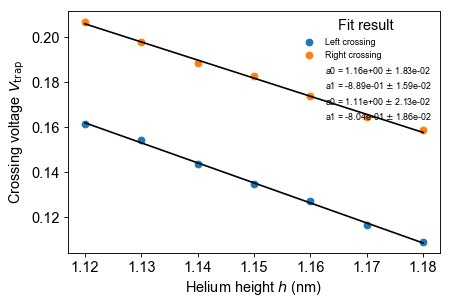

In [7]:
crossings_idcs = list()
for m, h in enumerate(hs):
    below_resonator_idx = common.find_nearest(4, electron_frequencies[m,:])
    
    # Left and right are reversed, because Vtrap is gets smaller
    right_crossing_idx = common.find_nearest(6.45, electron_frequencies[m, :below_resonator_idx])
    left_crossing_idx = below_resonator_idx + common.find_nearest(6.45, electron_frequencies[m, below_resonator_idx:])
    crossings_idcs.append((left_crossing_idx, right_crossing_idx))
    
crossings = np.array(crossings_idcs)
left_crossing_voltages = Vtraps[crossings[:, 0]]
right_crossing_voltages = Vtraps[crossings[:, 1]]
    
fig = plt.figure(figsize=(6.,4.))
common.configure_axes(13)
plt.plot(hs, left_crossing_voltages, 'o', label="Left crossing")
plt.plot(hs, right_crossing_voltages, 'o', label="Right crossing")

fr_left, ferr = kfit.fit_poly(np.array(hs), left_crossing_voltages, fitparams=[0, -1])
plt.plot(hs, kfit.polyfunc(np.array(hs), *fr_left), '-k')

fr_right, ferr = kfit.fit_poly(np.array(hs), right_crossing_voltages, fitparams=[0, -1])
plt.plot(hs, kfit.polyfunc(np.array(hs), *fr_right), '-k')

plt.xlabel("Helium height $h$ (nm)")
plt.ylabel("Crossing voltage $V_\mathrm{trap}$")

print("Effective voltage broadening due to z-displacement:(left) %.2f mV/nm and (right) %.2f mV/nm" % \
      (np.abs(fr_left[1]), np.abs(fr_right[1])))

if 0: 
    common.save_figure(fig, save_path=r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6\With L3 etch - just trap\Helium Fluctuation Files")

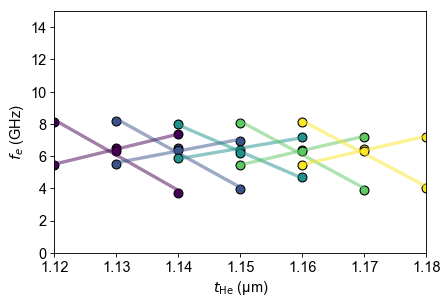

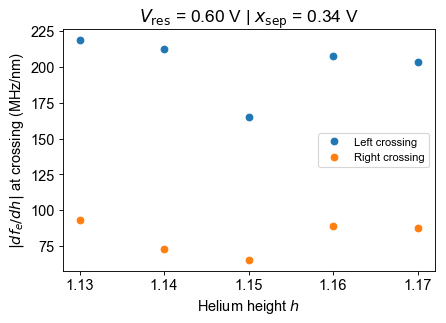

In [8]:
# Frequency at a particular index
ghz_nm_left, ghz_nm_right = list(), list()
these_hs = hs[1:-1]
colors = [plt.cm.viridis(n) for n in np.linspace(0, 1, len(these_hs))]

plt.figure()

for n, hoi in enumerate(these_hs):
    hidx = common.find_nearest(hoi, np.array(hs))
    hplot = np.array(hs)[hidx-1:hidx+2]
    right_voi_idx = crossings[hidx, 1]
    left_voi_idx = crossings[hidx, 0]

    plt.plot(hs[hidx-1:hidx+2], electron_frequencies[hidx-1:hidx+2, right_voi_idx], 'o', label="Right crossing", 
             ms=8, mec='k', color=colors[n])
    plt.plot(hs[hidx-1:hidx+2], electron_frequencies[hidx-1:hidx+2, left_voi_idx], 'o', label="Left crossing", 
             ms=8, mec='k', color=colors[n])

    fr_right, ferr = kfit.fit_poly(np.array(hs)[hidx-1:hidx+2], electron_frequencies[hidx-1:hidx+2, right_voi_idx], 
                                   fitparams=[0, 1], verbose=False)
    plt.plot(hplot, kfit.polyfunc(hplot, *fr_right), '-', lw=3, alpha=0.5, color=colors[n])

    fr_left, ferr = kfit.fit_poly(np.array(hs)[hidx-1:hidx+2], electron_frequencies[hidx-1:hidx+2, left_voi_idx], 
                                  fitparams=[0, 1], verbose=False)
    plt.plot(hplot, kfit.polyfunc(hplot, *fr_left), '-', lw=3, alpha=0.5, color=colors[n])

    ghz_nm_left.append(fr_left[1])
    ghz_nm_right.append(fr_right[1])
    
plt.ylim(0, 15)
plt.xlabel("$t_\mathrm{He}$ (%sm)"%(chr(956)))
plt.ylabel("$f_e$ (GHz)")
plt.xlim(np.min(hs), np.max(hs))
    
fig = plt.figure(figsize=(6.,4.))
common.configure_axes(13)
plt.title("$V_\mathrm{res}$ = %.2f V | $x_\mathrm{sep}$ = %.2f V" % (resonator, xsep))
plt.plot(these_hs, np.abs(ghz_nm_left), 'o', label="Left crossing")
plt.plot(these_hs, np.abs(ghz_nm_right), 'o', label="Right crossing")
plt.xlabel("Helium height $h$")
plt.ylabel("$|df_e/dh|$ at crossing (MHz/nm)")
plt.legend(loc=0, prop={"size" : 10}, frameon=1)

if 0: 
    common.save_figure(fig, save_path=r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6\With L3 etch - just trap\Helium Fluctuation Files")

For a single $h$, show how the frequency changes with $t_\mathrm{He}$

Evaluating slope at the crossing for t_He = 1.15 μm
Slope of each line is -204 MHz/nm (left crossing) and 79 MHz/nm (right crossing)


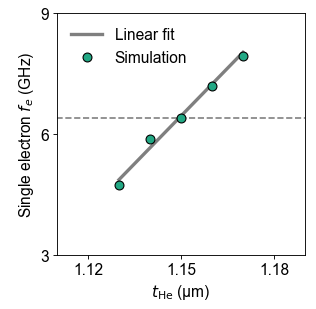

In [21]:
# Frequency at a particular index
ghz_micron_left, ghz_micron_right = list(), list()
these_hs = [hs[3]]
fontsize = 14
print("Evaluating slope at the crossing for t_He = %.2f %sm" % (these_hs[0], chr(956)))

fig = plt.figure(figsize=(4.,4.))
common.configure_axes(fontsize)
ax = plt.gca()

for hoi in these_hs:
    hidx = common.find_nearest(hoi, np.array(hs))
    right_voi_idx = crossings[hidx, 1]
    left_voi_idx = crossings[hidx, 0]
    hplot = np.array(hs[hidx-2:hidx+3])
    
#     ax.plot(hs, electron_frequencies[:, left_voi_idx], 'o', label="Left crossing")

    fr_right, ferr = kfit.fit_poly(np.array(hs)[hidx-2:hidx+2], electron_frequencies[hidx-2:hidx+2, right_voi_idx], 
                                   fitparams=[0, 1], verbose=False)
    ax.plot(hplot, kfit.polyfunc(hplot, *fr_right), '-k', lw=3, alpha=0.5, label="Linear fit")
    ax.plot(hs[hidx-2:hidx+3], electron_frequencies[hidx-2:hidx+3, right_voi_idx], 'o', 
            label="Simulation", lw=1, color=plt.cm.viridis(0.6), ms=8, mec='k')
    
#     fr_left, ferr = kfit.fit_poly(np.array(hs)[hidx-1:hidx+2], electron_frequencies[hidx-1:hidx+2, left_voi_idx], 
#                                   fitparams=[0, 1], verbose=False)
#     ax.plot(hs, kfit.polyfunc(np.array(hs), *fr_left), '-k')

    ghz_micron_left.append(fr_left[1])
    ghz_micron_right.append(fr_right[1])
    

ax.set_xlim(these_hs[0] - 0.04, these_hs[0] + 0.04)    
ax.set_ylim(3, 9)
ax.hlines(6.40, these_hs[0] - 0.1, these_hs[0] + 0.1, linestyles='--', color='gray')
ax.set_xlabel("$t_\mathrm{He}$ (%sm)"%chr(956))
ax.set_ylabel("Single electron $f_e$ (GHz)")
ax.set_yticks([3, 6, 9])
ax.set_xticks([1.12, 1.15, 1.18])
# ax.text(1.08, 7, "resonator $f_0$", va='center', ha='center')
ax.annotate("resonator $f_0$", xy=(1.06, 6.40),  xycoords='data',
            xytext=(1.07, 7.0),
            arrowprops=dict(arrowstyle="->",
                            shrinkA=0, shrinkB=0,
                            connectionstyle="angle,angleA=0,angleB=90,rad=10"))
ax.legend(loc=0, prop={"size" : fontsize}, frameon=False)

print("Slope of each line is %.0f MHz/nm (left crossing) and %.0f MHz/nm (right crossing)" % (ghz_micron_left[0], ghz_micron_right[0]))

if 1:
    fig.savefig(r"S:\Gerwin\Electron on helium\Papers\2017 - Circuit QED with a single electron on helium\Supplement\HeliumReservoir_b.pdf", 
                dpi=300, bbox_inches='tight', pad_inches=0)

# plt.xlim(np.min(hs), np.max(hs))
    
# fig = plt.figure(figsize=(6.,4.))
# common.configure_axes(13)
# plt.title("$V_\mathrm{res}$ = %.2f V | $x_\mathrm{sep}$ = %.2f V" % (resonator, xsep))
# plt.plot(these_hs, np.abs(ghz_nm_left), 'o', label="Left crossing")
# plt.plot(these_hs, np.abs(ghz_nm_right), 'o', label="Right crossing")
# plt.xlabel("Helium height $h$")
# plt.ylabel("$|df_e/dh|$ at crossing (MHz/nm)")
# plt.legend(loc=0, prop={"size" : 10}, frameon=1)

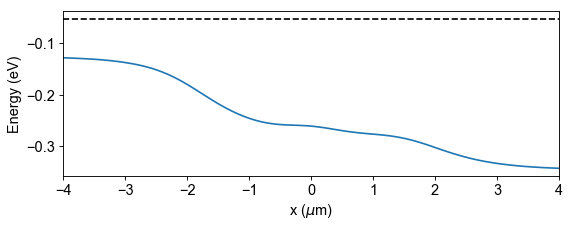

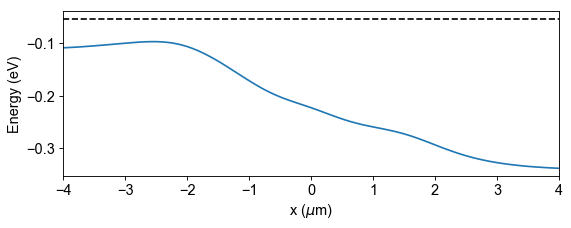

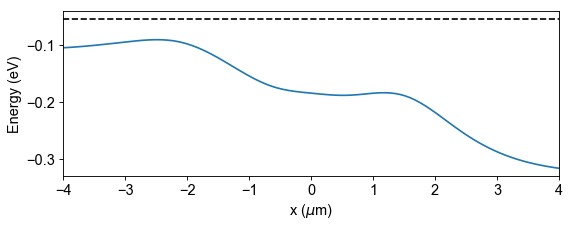

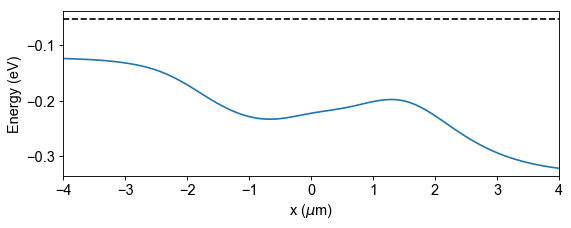

In [16]:
from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from ipywidgets import interact

t = trap_analysis.TrapSolver()
#x, y, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
x = output[0]['x'][:, :, 0]
y = output[0]['y'][:, :, 0]

import matplotlib as mpl
# common.configure_axes(13)
mpl.rcParams['figure.figsize'] = (8.,3.)
# fig = plt.figure(figsize=(8.,6.))

def plot_combined_potential(resonator=+0.60, trap=+0.2, resonatorguard=0, centerguard=0.00, 
                            trapguard=-0.0, scaling=0.0, 
                            color_minimum=-0.10, color_maximum=0.10, chemical_potential=-0.0525, 
                            trap_resg_locked=False, left_right_guard_locked=False, 
                            auto_scale=False):
    
    fig = plt.figure(figsize=(8.,6.))
    plt1 = fig.add_subplot(211)
    
    if trap_resg_locked:
        resonatorguard = 1/0.25*(trap - 0.30)
    if left_right_guard_locked:
        resonatorguard = trapguard
    coefficients = np.array([resonator, trap, resonatorguard, trapguard]) * 10**scaling
    
    for k, coeff in enumerate(coefficients):
        if k == 0: 
            combined_potential = coeff * output[k]['V'][:, :, 0]
        else:
            combined_potential += coeff * output[k]['V'][:, :, 0]
    
    TS = anneal.TrapAreaSolver(x[0,:], y[:,0], -combined_potential.T, smoothing=0.01)
    
    #print(np.shape(x), np.shape(y), np.shape(combined_potential))
    
    #combined_potential = t.get_combined_potential(cropped_potentials, coefficients)

    centeridx = int(np.shape(y)[0]/2)
    plt1.plot(x[0, :], TS.V(x[0,:], 0))#, color='darkorange')
    plt1.hlines(chemical_potential, np.min(x[0,:]), np.max(x[0,:]), linestyles='--')
    #plt.plot(x[centeridx, :], -combined_potential[centeridx, :], color='darkorange')
    plt.gca().set_axis_bgcolor('none')
        
    ymin, ymax = np.min(-combined_potential[centeridx,:]), np.max(-combined_potential[centeridx,:])
    
    print(x[0, np.argmin(-combined_potential[centeridx,:int(np.shape(combined_potential)[1]/2)])])
    #plt.xlabel("x ($\mu$m)")
    plt.ylabel("Energy (eV)")
    plt.xlim(np.min(x), np.max(x))
    if not auto_scale:
        plt.ylim(color_minimum, color_maximum)
    else:
        color_minimum, color_maximum = plt.ylim()
        #plt.ylim(-0.7, -0.65)
        
    biasVoltages = "$V_{res}$ = %.4f\n$V_{trap}$ = %.4f\n$V_{rguard}$ = %.4f\n$V_{tguard}$ = %.4f\n" % \
    (resonator * 10**scaling, trap * 10**scaling, resonatorguard * 10**scaling, trapguard * 10**scaling)
    
#     plt.text(2, ymin + 0.2*(ymax-ymin), biasVoltages)
#     plt.vlines([1.0, 2.0], ymin, ymax, linestyles='--', color='k')
    
#     plt.subplot(212)
#     plt.pcolormesh(x, y, -combined_potential, cmap=plt.cm.RdBu_r, 
#                         vmin=color_minimum, vmax=color_maximum)
    plt.xlabel("x ($\mu$m)")
#     plt.ylabel("y ($\mu$m)")
#     plt.xlim(np.min(x), np.max(x))
#     plt.ylim(np.min(y), np.max(y))
    
    
interact(plot_combined_potential, resonator=(-5.0, 5.0, 0.05), trap=(-5, 5, 0.05), 
         resonatorguard=(-5, 5, 0.05), centerguard=(-5,5, 0.05), trapguard=(-5, 5, 0.05), scaling=(-2.0, 1.0, 0.01),
         chemical_potential=(-5, 5, 0.05), color_minimum=(-5, 5, 0.05), color_maximum=(-5, 5, 0.05), 
         trap_resg_locked=False, left_right_guard_locked=False, auto_scale=True);

## Curvatures

100%|██████████| 16/16 [01:46<00:00,  6.46s/it]


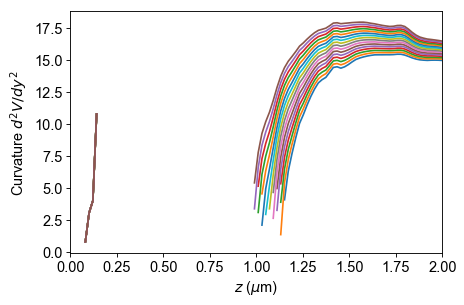

In [8]:
names = ["Resonator", "Trap", "Resonatorguard", "Trapguard"]

plt.figure()

for Vtraps in tqdm(np.linspace(0.15, 0.30, 16)):
    volts = [0.60, Vtraps, -0.35, 0.00]
    
    for k, name in enumerate(names):
        datapath = r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6\With L3 etch - just trap\Helium Fluctuation Files - multiple h (d = 1200 nm)"
        df = os.path.join(datapath, "%s_2D_Curvature_XZ.dsp" % name)

        xeval = np.linspace(-4, 4, 100)
        zeval = np.linspace(0, 2, 100)

        elements, nodes, solution, bbox = load_dsp(df, line_nr=[92, 93, 94, 91])
        xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, solution)
        xcenter = np.mean(bbox[0:2])
        ycenter = np.mean(bbox[2:4])
        xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=zeval, clim=None, 
                                                             plot_axes='xz', cmap=plt.cm.viridis, plot_mesh=0, plot_data=0)

        if k == 0: 
            curvature_total = Uinterp * volts[k]
        else:
            curvature_total += Uinterp * volts[k]

    xoi = -0.5
    xoi_idx = common.find_nearest(xoi, xinterp)

    plt.plot(yinterp[:, xoi_idx], np.sqrt(-1.602E-19 * curvature_total[:, xoi_idx] / 9.11E-31) / (2 * np.pi * 1E9), 
             label=Vtraps)
    # plt.ylim(-1E11, 0)

plt.xlim(0, 2)
plt.xlabel("$z$ ($\mu$m)")
plt.ylabel("Curvature $d^2 V/dy^2$ ")
        
# plt.figure(figsize=(8.,4.))
# common.configure_axes(13)
# plt.pcolormesh(xinterp, yinterp, curvature_total)
# plt.xlabel("$x$ ($\mu$m)")
# plt.ylabel("$z$ ($\mu$m)")
# plt.title("Combined $d^2 V/d y^2$")

# plt.colorbar()
# plt.clim(0E11, 7E11)

C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


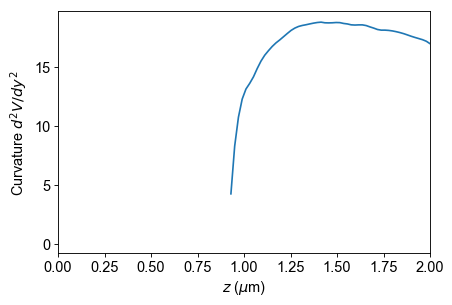

In [25]:
xoi = -0.5
xoi_idx = common.find_nearest(xoi, xinterp)

plt.figure()
plt.plot(yinterp[:, xoi_idx], np.sqrt(-1.602E-19 * curvature_total[:, xoi_idx] / 9.11E-31) / (2 * np.pi * 1E9))
# plt.ylim(-1E11, 0)
plt.xlim(0, 2)
plt.xlabel("$z$ ($\mu$m)")
plt.ylabel("Curvature $d^2 V/dy^2$ ")